In [11]:
import cv2
import numpy as np
import scipy.signal as sig
from scipy import ndimage as ndi


def generalized_sobel(n):

    x_sob = np.array([(-1, 0, 1), (-2, 0, 2), (-1, 0, 1)]) 
    y_sob = np.array([(1, 2, 1), (0, 0, 0), (-1, -2, -1)]) 
  
    m = np.zeros([n,n])
    m_y = np.zeros([n,n])
    
    if n !=3 :
      
        m[0][0] = x_sob[0][0]
        m[0][int(np.floor(n/2))] = x_sob[0][1]
        m[0][n-1] = x_sob[0][2]
              
        m[int(np.floor(m.shape[0]/2))][0] = x_sob[1][0]
        m[int(np.floor(m.shape[0]/2))][int(np.floor(m.shape[0]/2))] = x_sob[1][1]
        m[int(np.floor(m.shape[0]/2))][n-1] = x_sob[1][2]
              
        m[n-1][0] = x_sob[2][0]
        m[n-1][int(np.floor(m.shape[0]/2))] = x_sob[2][1]
        m[n-1][n-1] = x_sob[2][2]
      
        m_y[0][0] = y_sob[0][0]
        m_y[0][int(np.floor(n/2))] = y_sob[0][1]
        m_y[0][n-1] = y_sob[0][2]
              
        m_y[int(np.floor(m.shape[0]/2))][0] = y_sob[1][0]
        m_y[int(np.floor(m.shape[0]/2))][int(np.floor(m.shape[0]/2))] = y_sob[1][1]
        m_y[int(np.floor(m.shape[0]/2))][n-1] = y_sob[1][2]
              
        m_y[n-1][0] = y_sob[2][0]
        m_y[n-1][int(np.floor(m.shape[0]/2))] = y_sob[2][1]
        m_y[n-1][n-1] = y_sob[2][2]
              
    elif n == 3:
        m = x_sob
        m_y = y_sob
      
    return m, m_y

def my_conv(img, kernel):
    # write your convolution function
    h = img.shape[0] 
    w = img.shape[1]
  
    # The result size of a convolution
    num_missing_pixels = kernel.shape[0]-1
    conv_size_x = img.shape[0]-num_missing_pixels
    conv_size_y = img.shape[1]-num_missing_pixels
  
  
    filter_img = np.empty([conv_size_x,conv_size_y])
  
    filter_ch1 = np.empty([conv_size_x,conv_size_y])
    filter_ch2 = np.empty([conv_size_x,conv_size_y])
    filter_ch3 = np.empty([conv_size_x,conv_size_y])
  
    kernel_size = kernel.shape[0]
    for channel in range(img.shape[2]):
        img_channel = img[:,:,channel]
        for i in range(h - num_missing_pixels):
            for j in range(w - num_missing_pixels):
                im_region = img_channel[i:(i + kernel_size), j:(j + kernel_size)]
                filter_img[i,j] = np.sum(im_region*kernel)

          
        if channel == 0:
            filter_ch1 = filter_img
        elif channel == 1:
            filter_ch2 = filter_img
        elif channel == 2:
            filter_ch3 = filter_img

    return (filter_ch1 + filter_ch2 + filter_ch3 ) / 3 

def get_inputs():
    pointer = True
    while pointer == True:
        print("Please write kernel size as an odd number")  
        kernel_size = input()
        if (int(kernel_size)%2) !=0:
            pointer = False
    return kernel_size

def Gradient_Direction(fx, fy):
    g_dir = np.zeros((fx.shape[0], fx.shape[1]))
    g_dir = np.rad2deg(np.arctan2(fy, fx)) + 180
    return g_dir

def Digitize_angle(Angle):
    quantized = np.zeros((Angle.shape[0], Angle.shape[1]))
    for i in range(Angle.shape[0]):
        for j in range(Angle.shape[1]):
            if 0 <= Angle[i, j] <= 22.5 or 157.5 <= Angle[i, j] <= 202.5 or 337.5 < Angle[i, j] < 360:
                quantized[i, j] = 0
            elif 22.5 <= Angle[i, j] <= 67.5 or 202.5 <= Angle[i, j] <= 247.5:
                quantized[i, j] = 1
            elif 67.5 <= Angle[i, j] <= 122.5 or 247.5 <= Angle[i, j] <= 292.5:
                quantized[i, j] = 2
            elif 112.5 <= Angle[i, j] <= 157.5 or 292.5 <= Angle[i, j] <= 337.5:
                quantized[i, j] = 3
    return quantized

def Non_Max_Supp(qn, magni, D):
    M = np.zeros(qn.shape)
    a, b = np.shape(qn)
    for i in range(a-1):
        for j in range(b-1):
            if qn[i,j] == 0:
                if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j]==1:
                if  magni[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0       
            if qn[i,j] == 2:
                if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j] == 3:
                if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
    return M

def double_thresholding(g_suppressed, low_threshold, high_threshold):
    g_thresholded = np.zeros(g_suppressed.shape)
    for i in range(0, g_suppressed.shape[0]):		# loop over pixels
        for j in range(0, g_suppressed.shape[1]):
            if g_suppressed[i,j] < low_threshold:	# lower than low threshold
                g_thresholded[i,j] = 0
            elif g_suppressed[i,j] >= low_threshold and g_suppressed[i,j] < high_threshold: 	# between thresholds
                g_thresholded[i,j] = 128
            else:					        # higher than high threshold
                g_thresholded[i,j] = 255
    return g_thresholded

def hysteresis(g_thresholded):
    g_strong = np.zeros(g_thresholded.shape)
    for i in range(0, g_thresholded.shape[0]):		# loop over pixels
        for j in range(0, g_thresholded.shape[1]):
            val = g_thresholded[i,j]
            if val == 128:			# check if weak edge connected to strong
                if g_thresholded[i-1,j] == 255 or g_thresholded[i+1,j] == 255 or g_thresholded[i-1,j-1] == 255 or g_thresholded[i+1,j-1] == 255 or g_thresholded[i-1,j+1] == 255 or g_thresholded[i+1,j+1] == 255 or g_thresholded[i,j-1] == 255 or g_thresholded[i,j+1] == 255:
                    g_strong[i,j] = 255		# replace weak edge as strong
            elif val == 255:
                g_strong[i,j] = 255		# strong edge remains as strong edge
    return g_strong


def gaussian_kernel():
    pointer = True
    while pointer == True:
        print("Please write kernel size")  
        k_size = int(input())
        print("Please write sigma value")  
        sigma = int(input())
        pointer = False
            
    center = k_size // 2
    x, y = np.mgrid[0 - center : k_size - center, 0 - center : k_size - center]
    g = 1 / (2 * np.pi * sigma) * np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    return g


In [2]:
print("Please write absolute path of the image e.g. F:/yedek/Ders PDF/4.S/II/Computer Vision/Homework1/image2.png \n")
path = input()
img_raw = cv2.imread(path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
kernel_size = get_inputs()
  
kernel_x, kernel_y = generalized_sobel(int(kernel_size))
  
img = my_conv(img_raw, kernel_x)

Please write absolute path of the image e.g. F:/yedek/Ders PDF/4.S/II/Computer Vision/Homework1/image2.png 

F:/yedek/Ders PDF/4.S/II/Computer Vision/Homework1/image2.png
Please write kernel size as an odd number
5


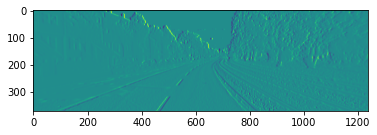

In [3]:
#img = cv2.imread('/Users/mustafa/test.jpg')
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
import matplotlib.pyplot as plt
plt.imshow(img)
#plt.title('my picture')
#plt.show()

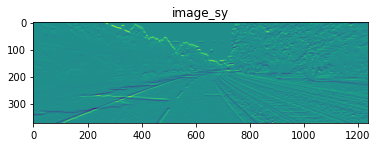

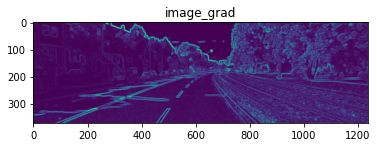

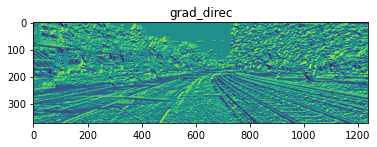

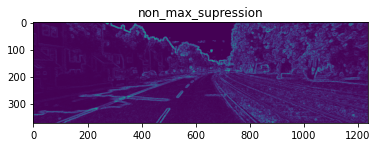

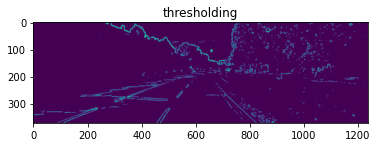

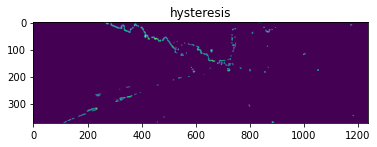

In [4]:
 # writes image to a file
plt.imshow(img)
plt.title('image_sx')

#cv2.imwrite("image_sx.jpg",img)


img2 = my_conv(img_raw, kernel_y)
plt.imshow(img2)
plt.title('image_sy')
plt.show()
#cv2.imwrite("image_sy.jpg",img2)


img3 = np.sqrt(img**2 + img2**2)
img3 = img3 * 100 / img3.max()
plt.imshow(img3)
plt.title('image_grad')
plt.show()
#cv2.imwrite("image_grad.jpg",img3)
   
grad_direc = np.zeros((img.shape[0], img.shape[1]))
theta = np.arctan2(np.float32(img2), np.float32(img))
grad_direc = np.rad2deg(theta) + 180

plt.imshow(grad_direc)
plt.title('grad_direc')
plt.show()
#cv2.imwrite("grad_direc.jpg",grad_direc)
  
quantized = Digitize_angle(grad_direc)
nms = Non_Max_Supp(quantized, grad_direc, img3)
plt.imshow(nms)
plt.title('non_max_supression')
plt.show()
#cv2.imwrite("non_max_supression.jpg",nms)

threshold = double_thresholding(nms, 30, 60)
plt.imshow(threshold)
plt.title('thresholding')
plt.show()
#cv2.imwrite("thresholding.jpg",threshold)
  
hys = hysteresis(threshold)
plt.imshow(hys)
plt.title('hysteresis')
plt.show()
#cv2.imwrite("hysteresis.jpg",hys)

In [12]:
gaus_filter = gaussian_kernel()

Ixx = sig.convolve2d(img, gaus_filter, mode="same")#my_conv(img, gaus_filter)
Ixy = sig.convolve2d(img2, gaus_filter, mode="same")#my_conv(img2, gaus_filter)
Iyy = sig.convolve2d((img*img2), gaus_filter, mode="same")# my_conv((img*img2), gaus_filter)
  
# Harris Function
threshold = 0.05
detA = Ixx*Iyy - (Ixy**2) 
traceA = Ixx + Iyy 
R_harris = detA - (threshold * (traceA**2))

Please write kernel size
3
Please write sigma value
2


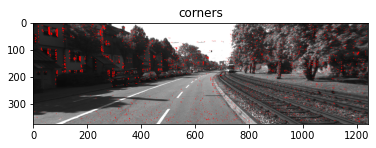

In [13]:


corners = np.copy(img_raw)
  
h_max = R_harris.max()
h_min = R_harris.min()
    
thres_corn = 0.001


for y, row in enumerate(R_harris):
      for x, pixel in enumerate(row):
            if pixel >= h_max*thres_corn:
                corners[y,x] = [255,0,0]


plt.imshow(corners)
plt.title('corners')
plt.show()

In [14]:
R_harris

array([[-3.93008723e+00, -9.32124633e+00, -9.39893494e+00, ...,
        -6.41449290e+03, -4.09542345e+03, -1.04193405e+03],
       [-6.20602404e-01, -3.34099059e+00, -3.46286462e+00, ...,
        -9.68170174e+03, -4.59454719e+03, -9.01944459e+02],
       [-2.69078633e+00, -3.59066162e+00, -2.99302696e+00, ...,
        -4.03854652e+03, -8.87645950e+02, -4.74414339e+01],
       ...,
       [-1.80426373e+03, -7.14206399e+02, -1.34748915e+03, ...,
        -1.77490421e+06, -1.99197669e+05, -1.55348668e+03],
       [-1.67460678e+02, -3.11236934e+02, -1.98501940e+03, ...,
        -2.62726295e+06, -3.99431654e+05, -1.05271741e+04],
       [-4.33407686e+02, -2.63698785e+02,  1.46941985e+02, ...,
        -1.72226557e+06, -3.31766835e+05, -1.69011194e+04]])